In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pop_tools

import cesm_tools
import project

Get the POP grid data.

In [14]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]
grid

<xarray.Dataset> Size: 4MB
Dimensions:      (nlat: 384, nlon: 320)
Dimensions without coordinates: nlat, nlon
Data variables:
    TAREA        (nlat, nlon) float64 983kB 1.125e+13 1.125e+13 ... 7.432e+12
    KMT          (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    TLAT         (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG        (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 319.4 319.8
    REGION_MASK  (nlat, nlon) int32 492kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

Set up a time axis for the forcing data set.

In [15]:
time_bnds = xr.cftime_range('1999-01-01', '2020-01-01', freq='1D', calendar='noleap')
time_bnds = xr.DataArray(np.vstack((time_bnds[:-1], time_bnds[1:])).T, dims=('time', 'd2'))
time = time_bnds.mean('d2')
time_bnds

<xarray.DataArray (time: 7665, d2: 2)> Size: 123kB
array([[cftime.DatetimeNoLeap(1999, 1, 1, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 2, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1999, 1, 2, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 3, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1999, 1, 3, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1999, 1, 4, 0, 0, 0, 0, has_year_zero=True)],
       ...,
       [cftime.DatetimeNoLeap(2019, 12, 29, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2020, 1, 1, 0, 0, 0, 0, has_year_zero=True)]],
      dtype=object)
Dimensions without coordinates: time, d2

In [16]:
time

<xarray.DataArray (time: 7665)> Size: 61kB
array([cftime.DatetimeNoLeap(1999, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1999, 1, 3, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2019, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Dimensions without coordinates: time

Set OAE loading rate

In [17]:
alk_mass_loading_rate_molm2yr = 10.0 # mol/m^2/yr
peryr_to_pers = 1.0 / 365.0 / 86400.0
alk_mass_loading_rate = alk_mass_loading_rate_molm2yr * peryr_to_pers # mol/m^2/s
alk_mass_loading_rate

3.170979198376459e-07

Construct forcing dataset template.

In [18]:
alk_forcing = xr.full_like(grid.TLAT.expand_dims({'time': time}), fill_value=0.0)
alk_forcing.name = 'alk_forcing'
alk_forcing.attrs['long_name'] = 'Alkalinity forcing'
alk_forcing.attrs['units'] = 'mol/m^2/s'


dso = xr.Dataset(dict(
    time=time,
    time_bnds=time_bnds,
    alk_forcing=alk_forcing,
    TLAT=grid.TLAT,
    TLONG=grid.TLONG,
    KMT=grid.KMT,
    TAREA=grid.TAREA,
)).set_coords(['time', 'TLAT', 'TLONG']).rename({'nlat': 'Y', 'nlon': 'X'})

dso['Y'] = xr.DataArray(np.arange(1, grid.sizes['nlat']+1), dims=('Y'))
dso['X'] = xr.DataArray(np.arange(1, grid.sizes['nlon']+1), dims=('X'))
dso.time.encoding['dtype'] = np.float64
dso.time.encoding['_FillValue'] = None
dso.time.encoding['units'] = 'days since 1999-01-01 00:00:00'
dso.time_bnds.encoding['dtype'] = np.float64
dso.time_bnds.encoding['_FillValue'] = None
dso.time.attrs['bounds'] = 'time_bnds'
dso

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 7665, d2: 2, Y: 384, X: 320)
Coordinates:
  * time         (time) object 61kB 1999-01-01 12:00:00 ... 2019-12-31 12:00:00
    TLAT         (Y, X) float64 983kB -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (Y, X) float64 983kB 320.6 321.7 322.8 ... 318.9 319.4 319.8
  * Y            (Y) int64 3kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * X            (X) int64 3kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
Dimensions without coordinates: d2
Data variables:
    time_bnds    (time, d2) object 123kB 1999-01-01 00:00:00 ... 2020-01-01 0...
    alk_forcing  (time, Y, X) float64 8GB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KMT          (Y, X) int32 492kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TAREA        (Y, X) float64 983kB 1.125e+13 1.125e+13 ... 7.432e+12

Specify loading rate in time.

<xarray.DataArray ()> Size: 8B
array(31.)

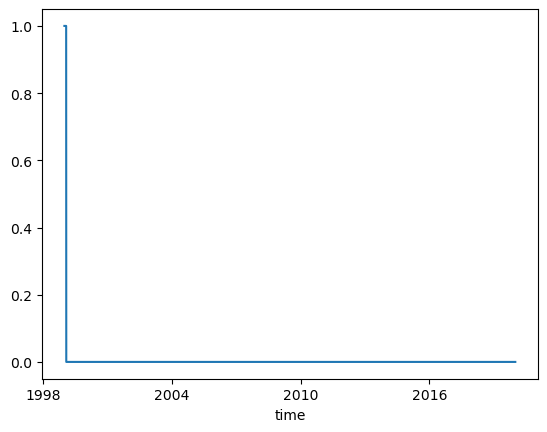

In [19]:
months_to_perturb = ['1999-01']

time_function = xr.DataArray(
    np.array([
        f'{d.year:04d}-{d.month:02d}' in months_to_perturb for d in time.values]).astype(np.float64),
    dims=('time'),
    coords={'time': time},
)
time_function.plot()
time_function.sum()

/tmp/ipykernel_2184/4001196389.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  region_mask.data[i, :, :] = xr.where(
/tmp/ipykernel_2184/4001196389.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  region_mask.data[i, :, :] = xr.where(
/tmp/ipykernel_2184/4001196389.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  region_mask.data[i, :, :] = xr.where(
/tmp/ipykernel_2184/4001196389.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  region_mask.data[i, :, :] = xr.where(
/tmp/ipykernel_2

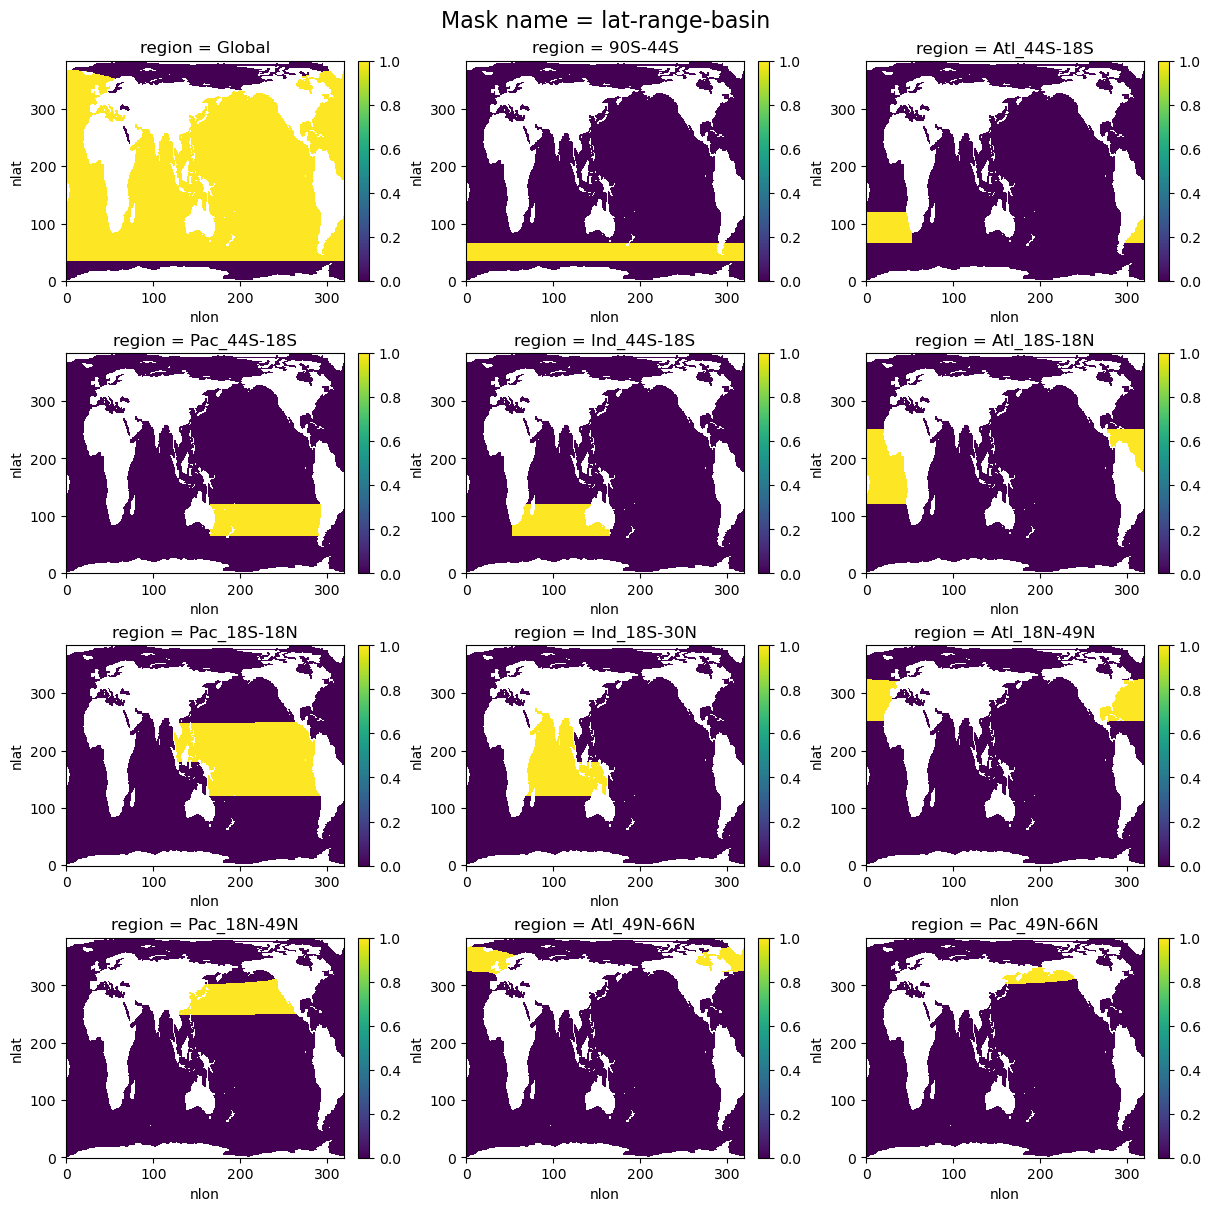

In [20]:
region_mask_name = 'lat-range-basin'

region_mask = pop_tools.region_mask_3d('POP_gx1v7', region_mask_name)

keep = np.ones(region_mask.sizes['region']).astype(bool)
for i in range(region_mask.sizes["region"]):
    region_mask.data[i, :, :] = xr.where(
        (region_mask[i, :, :] == 1.0) & (-60 < grid.TLAT) & (grid.TLAT < 66), 1.0, 0.0
    )
    if not region_mask[i, :, :].any():
        keep[i] = False

region_mask = region_mask[keep, :, :]
cesm_tools.visualize_mask(region_mask.where(grid.KMT > 0))

In [21]:
clobber = True
forcing_files = []
dir_out = f"{project.dir_data}/alk-forcing/{region_mask_name}"
os.makedirs(dir_out, exist_ok=True)

for i in range(0, region_mask.shape[0]):

    file_out = f'{dir_out}/alk-forcing-{region_mask_name}_{i:03d}.nc'
    if os.path.exists(file_out) and not clobber:
        continue

    dso.alk_forcing.data[:] = 0.0
    alk_forcing = time_function * xr.where(region_mask[i, :, :], alk_mass_loading_rate, 0.0)  
    alk_forcing = alk_forcing.reset_coords('region', drop=True)
    dso.alk_forcing.data = alk_forcing

    cesm_tools.to_netcdf_clean(dso, file_out)
    forcing_files.append(file_out)

    break
    
forcing_files

------------------------------
Writing /global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/alk-forcing/lat-range-basin/alk-forcing-lat-range-basin_000.nc

netcdf alk-forcing-lat-range-basin_000 {
dimensions:
	Y = 384 ;
	X = 320 ;
	time = 7665 ;
	d2 = 2 ;
variables:
	int KMT(Y, X) ;
		KMT:long_name = "k Index of Deepest Grid Cell on T Grid" ;
		KMT:coordinates = "TLONG TLAT" ;
	float TAREA(Y, X) ;
		TAREA:units = "cm^2" ;
		TAREA:long_name = "area of T cells" ;
		TAREA:coordinates = "TLONG TLAT" ;
	double TLAT(Y, X) ;
		TLAT:units = "degrees_north" ;
		TLAT:long_name = "T-grid latitude" ;
	double TLONG(Y, X) ;
		TLONG:units = "degrees_east" ;
		TLONG:long_name = "T-grid longitude" ;
	int X(X) ;
	int Y(Y) ;
	float alk_forcing(time, Y, X) ;
		alk_forcing:units = "mol/m^2/s" ;
		alk_forcing:long_name = "Alkalinity forcing" ;
		alk_forcing:coordinates = "TLAT TLONG" ;
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1999-01-01" ;
		time:calendar = "no

['/global/cfs/projectdirs/m4746/Projects/OAE-Efficiency-Map/data/alk-forcing/lat-range-basin/alk-forcing-lat-range-basin_000.nc']